In [1]:
import sys
sys.path.append('C:\Program Files\Python37\Lib\site-packages')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [2]:
# MNIST data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

#raise Exception('Make sure the above uses the right directory - it should be ../MNIST if you are in a folder')
train_dataset = torchvision.datasets.MNIST('../MNIST/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('../MNIST/', train=False, transform=transform, download=True)

MNIST_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
MNIST_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

MNIST_labels = list(range(10))

# CIFAR data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#raise Exception('Make sure the below uses the right directory - it should be ../CIFAR if you are in a folder')
trainset = torchvision.datasets.CIFAR10('../CIFAR/', train=True,
                                        download=True, transform=transform)
CIFAR_train_loader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../CIFAR/', train=False,
                                       download=True, transform=transform)
CIFAR_test_loader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=2)



CIFAR_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



# XOR data
xor_inputs = torch.tensor(np.array([[1.0, 1], [0, 1], [1, 0], [0, 0]])).float()
xor_labels = torch.tensor(np.array([0, 1, 1, 0])).float().view(-1, 1)

xor_dataset = torch.utils.data.TensorDataset(xor_inputs, xor_labels)
xor_loader = torch.utils.data.DataLoader(xor_dataset, batch_size=4)



x = np.linspace(-1, 2, 100)
y = np.linspace(-1, 2, 100)
xv, yv = np.meshgrid(x, y)

x = xv.reshape(-1, 1)
y = yv.reshape(-1, 1)

xor_grid = torch.tensor(np.concatenate((x, y), axis=1)).float()

Files already downloaded and verified
Files already downloaded and verified


In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(3, 32, 3)#convolution layers for edges, corners, diagonals, etc.
        self.pool = nn.MaxPool2d(2, 2)#in a 1x1 square, choose the largest pixel
        self.fc1 = nn.Linear(32*15*15, 500)#first layer of nodes, that has to be the dimensions 
                                            #of the image by the number of nodes in layer 2
        self.fc2 = nn.Linear(500, 100)#second layer
        self.fc3 = nn.Linear(100, 10)#third layer
        self.activation = torch.nn.ReLU()#activation function, tanh of ReLU

    def forward(self, x):
        x = self.activation(self.conv(x))#activate the convolution using the activation function
        x = self.pool(x)#do the pooling
        x = x.view(x.size(0), -1)#set up the size
        x = self.activation(self.fc1(x))#run layer 1
        x = self.activation(self.fc2(x))#run layer 2
        x = self.fc3(x)#run layer 3
        return x

In [47]:
n_epochs = 1000
network = Net()
optimizer = optim.SGD(network.parameters(), 0.2, 0.0, 0, 0.01)
lossFunc = torch.nn.CrossEntropyLoss()

In [48]:
def train(epoch):
    network.train()#put the network in train mode
    for batch_idx, (data, target) in enumerate(CIFAR_train_loader):
        optimizer.zero_grad()#move towards the 0 gradient
        output = network(data)
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(CIFAR_train_loader.dataset),
                  100. * batch_idx / len(CIFAR_train_loader), 100. * correct.numpy() / 100))

In [49]:
def test():
    network.eval()#put the network in evaluation mode
    correct = 0
    with torch.no_grad():
        for data, target in CIFAR_test_loader:
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct.numpy(), len(CIFAR_test_loader.dataset),
          100. * correct.numpy() / len(CIFAR_test_loader.dataset)))

In [50]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Accuracy: 1001/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Accuracy: 13.000000
Train Epoch: 1 [10000/50000 (20%)]	Accuracy: 36.000000
Train Epoch: 1 [20000/50000 (40%)]	Accuracy: 43.000000
Train Epoch: 1 [30000/50000 (60%)]	Accuracy: 40.000000
Train Epoch: 1 [40000/50000 (80%)]	Accuracy: 47.000000

Test set: Accuracy: 4107/10000 (41%)

Train Epoch: 2 [0/50000 (0%)]	Accuracy: 40.000000
Train Epoch: 2 [10000/50000 (20%)]	Accuracy: 49.000000
Train Epoch: 2 [20000/50000 (40%)]	Accuracy: 54.000000
Train Epoch: 2 [30000/50000 (60%)]	Accuracy: 50.000000
Train Epoch: 2 [40000/50000 (80%)]	Accuracy: 44.000000

Test set: Accuracy: 4735/10000 (47%)

Train Epoch: 3 [0/50000 (0%)]	Accuracy: 47.000000
Train Epoch: 3 [10000/50000 (20%)]	Accuracy: 44.000000
Train Epoch: 3 [20000/50000 (40%)]	Accuracy: 50.000000
Train Epoch: 3 [30000/50000 (60%)]	Accuracy: 42.000000
Train Epoch: 3 [40000/50000 (80%)]	Accuracy: 57.000000

Test set: Accuracy: 5274/10000 (53%)

Train Epoch: 4 [0/50000 (0%)]	Accu

KeyboardInterrupt: 

In [51]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,#creates a matrix to show what the network confuses
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

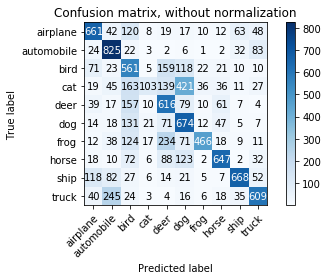

In [52]:
for data, target in CIFAR_test_loader:
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]
    plot_confusion_matrix(target.numpy(), pred.numpy(), classes=CIFAR_labels, normalize=False,
                          title='Confusion matrix, without normalization')